# Example: Nonimpulsive Maneuvers

Consider a 1000 kg spacecraft with an ion propulsion system. These systems are capable of extremely high efficiency but generally have low thrust. This particular system has an $I_{sp}$ of 10,000 s and a thrust of 2.5 N. The spacecraft is in a 300 km circular, equatorial, orbit around Earth. At $t$ = 0, the ion propulsion system is turned on, and remains on until the spacecraft reaches GEO. How long does it take for the spacecraft to reach GEO? How many orbital revolutions does it take to get to GEO? How much mass is used during the maneuver? Compare this propellant usage to a typical, high-thrust (impulsive) maneuver with a rocket with $I_{sp}$ of 300 s.

## Solution

To solve this problem, we will integrate the equations of motion with respect to time. Since the thrust is applied continuously, we cannot assume that the maneuver is impulsive. The equations of motion are given by:

$$\begin{aligned}\ddot{x} &= -\mu\frac{x}{r^3} + \frac{T}{m}\frac{\dot{x}}{v} & \ddot{y} &= -\mu\frac{y}{r^3} + \frac{T}{m}\frac{\dot{y}}{v} & \ddot{z} &= -\mu\frac{z}{r^3} + \frac{T}{m}\frac{\dot{z}}{v}\end{aligned}$$

In addition, we have to add an equation for the conservation of mass. Since the propulsion device works by ejecting mass overboard, the mass is reduced as the thrust is applied. This is given by:

$$\frac{dm}{dt} = -\frac{T}{I_{sp}g_0}$$

Now we need to construct the initial state vector. The state vector will have 7 components, the three position coordinates, the three velocity components, and the mass. Since the initial orbit is circular, the initial position is arbitrary, so we will chose it to be on the $x$ axis for convenience. In turn, this means that the only initial velocity component is in the $y$ direction:

$$\vector{v}_0 = \sqrt{\frac{\mu}{r_0}}\uvec{\jmath}$$

The final radius, $r_2$, is 42,164 km, at GEO.

In [14]:
import numpy as np
from scipy.integrate import solve_ivp
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

R_E = 6378  # km
mu = 3.986E5  # km**3/s**2

r_LEO = R_E + 300  # km
v_LEO = np.sqrt(mu / r_LEO)  # km/s

r_2 = 42_164  # km, GEO

r_0 = np.array((r_LEO, 0, 0))  # km
v_0 = np.array((0, v_LEO, 0))  # km/s
m_0 = np.array((1000))  # kg
Y_0 = np.hstack((r_0, v_0, m_0))

T = 2.5E-3  # kN
I_sp = 10_000  # s
g_0 = 9.807E-3  # km/s**2

Now we need to define the function that calculates the right hand side of the system of equations. For convenience, we will call the solution vector `Y`.

In [8]:
def nonimpulsive_maneuver(t, Y, mu, T, I_sp, g_0, r_2):
    """Residual function for non-impulsive maneuvers.
    
    t: Current simulation time
    Y: State vector [x y z xdot ydot zdot m], km, km/s, kg
    mu: Gravitational parameter, km**3/s**2
    T: Thrust, kN
    I_sp: Specific impulse, s
    g_0: Standard sea-level gravity, km/s**2
    """
    r = np.sqrt(np.dot(Y[0:3], Y[0:3]))
    v = np.sqrt(np.dot(Y[3:6], Y[3:6]))
    m = Y[-1]
    dY_dt = np.zeros(len(Y))
    dY_dt[0:3] = Y[3:6]
    dY_dt[3:6] = -mu * Y[0:3] / r**3 + T * Y[3:6] / (m * v)
    dY_dt[-1] = - T / (I_sp * g_0)
    return dY_dt

In addition to the function defining the residual, we will define several event functions. The SciPy ODE solver will find the time when the return value of an event function is zero and store that as part of the solution. We can also use events to terminate the integration before the specified end time. Event functions are regular Python functions that return a floating point value; the solver then records the time and solution vector when a zero value is returned.

Note that the function arguments for the event functions must be the same as the residual function, even if the arguments are not used.

First, we will define a function that determines whether the spacecraft has reached GEO. This will happen when the orbital radius is equal to $r_2$ above, or when the difference between the current radius and the desired radius is zero.

In [3]:
def reached_destination(t, Y, mu, T, I_sp, g_0, r_2):
    """Determine if the spacecraft reaches the destination radius.
    
    Returns the difference between the current orbital radius and the
    destination radius.
    """
    r_vec = Y[0:3]
    r = np.sqrt(np.dot(r_vec, r_vec))
    return r - r_2

When the spacecraft reaches the destination radius, we no longer need to keep integrating, so we can set the `terminal` attribute on the event function to be equal to `True`.

In [4]:
reached_destination.terminal = True

We also know that the mass of the spacecraft cannot go below zero. Here, we define a function that only returns the last element of the solution vector, which is the current value of the mass. If this becomes zero, the integration should terminate.

In [5]:
def mass(t, Y, mu, T, I_sp, g_0, r_2):
    """Return the current mass of the spacecraft.
    
    The mass is stored in the last element of the solution vector.
    If this becomes zero, the integration should terminate.
    """
    return Y[-1]

mass.terminal = True

Finally, to determine the number of orbits that occur, we want to know the number of times that the $y$-component of the position crosses zero. This happens twice on each orbit. To avoid double counting, we can use the `direction` attribute to only trigger the event when the zero crossing happens in a particular direction:

* `direction = -1`: Record when the zero crossing goes from positive to negative
* `direction = 1`: Record when the zero crossing goes from negative to positive
* `direction = 0`: Record every time that the event happens

In [6]:
def orbit(t, Y, mu, T, I_sp, g_0, r_2):
    """Trigger when the y-component of the position crosses zero.
    
    Useful to count the number of orbits."""
    return Y[1]

# Only trigger when going from negative to positive
orbit.direction = 1

Now we're ready to integrate. We pass the three event functions to the `events` keyword argument, and we'll set the maximum integration time to 2,000,000 seconds. We also want to get a million points worth of time steps for plotting.

The last things we need to adjust for the integrator are the tolerances and the integration method. The integrator tolerances control how accurate the solution produced by the integrator is. There are two tolerances, the _relative tolerance_ (`rtol`) and the _absolute tolerance_ (`atol`).

The relative tolerance determines roughly how many digits of precision will be correct in the answer, while the absolute tolerance determines roughly how close the solution is to an analytical solution. The default tolerances are `rtol=1E-3` and `atol=1E-6`, meaning that we can expect about 3 digits of precision and that the solution will be within about 1×10<sup>-6</sup> of an analytical solution.

Due to the very long integration time here, the default tolerances are not strict enough to achieve an accurate solution. My strategy to change the tolerances is to adjust them by three orders of magnitude at a time. This is a totally arbitrary strategy, but I've found it to be effective over the years. We should ensure that the solution does not change when we adjust the tolerances.

I found that I needed to set `rtol=1E-12` and `atol=1E-15` to have a stable answer. This is about as small as the tolerances can be set and still affect the solution. This is because computers represent floating point numbers with about 15 digits of precision, so setting `atol` to be smaller than 1×10<sup>-15</sup> does not affect the result any longer.

Using the default `method`, a 4th-order Runge-Kutta solver, with these tolerances took a very long time to solve. Fortunately, SciPy includes other solvers. In this case the `DOP853` solver, a 7th-order Runge-Kutta solver, is able to solve the problem in a more reasonable time.

With these changes, we can solve the problem.

In [9]:
t_end = 2_000_000  # s
t_eval = np.linspace(0, t_end, int(1E6))
sol = solve_ivp(
    nonimpulsive_maneuver,
    t_span=(0, t_end),
    y0=Y_0,
    t_eval=t_eval,
    events=(reached_destination, mass, orbit),
    rtol=1E-12,
    atol=1E-15,
    method="DOP853",
    args=(mu, T, I_sp, g_0, r_2)
)
print(sol.status)

1


The solution object is stored in `sol`, and we print `sol.status` at the end of the integration. If `sol.status` is `0`, the integrator reached the specified end time. If `sol.status` is `1`, the integration was terminated due to an event. In this case, the integration was terminated due to an event triggering.

The time and solution vector values for the events are stored in the `sol.t_events` and `sol.y_events` attributes, respectively. These attributes refer to lists, where each element of the list corresponds to one of the event functions, in the order that they were specified to the `events` keyword.

For this problem, the first element of `sol.t_events` is the time of the `reached_destination` event, the second element is the time of the `mass` event, and the third element are the times of the `orbit` counts. Since `reached_destination` and `mass` are terminal events, they can only occur once. We can print the `t_events` for those two events to see which was triggered:

In [11]:
print(sol.t_events[:2])

[array([1817381.70314193]), array([], dtype=float64)]


Here we can see that a time is reported for the first event (`reached_destination`) and not for the second event (`mass`). Thus, we conclude that the spacecraft reached its destination radius!

Now let's plot the solution. As before, we can get the solution vectors with the `sol.y` attribute:

In [12]:
r_vec = sol.y[0:3].T
r = np.sqrt(r_vec[:, 0]**2 + r_vec[:, 1]**2 + r_vec[:, 2]**2)
v_vec = sol.y[3:6].T
v = np.sqrt(v_vec[:, 0]**2 + v_vec[:, 1]**2 + v_vec[:, 2]**2)
m = sol.y[-1]

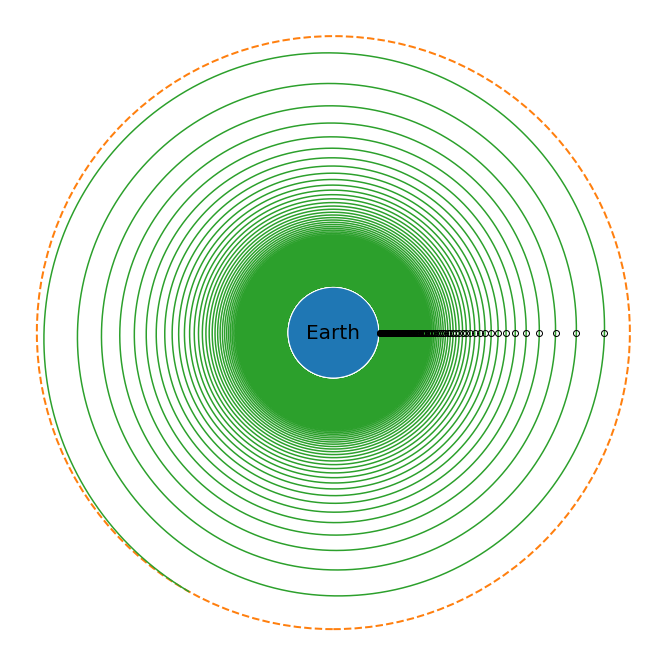

In [24]:
plt.rc("font", size=20)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect("equal")
ax.axis("off")
ax.add_patch(Circle((0, 0), R_E, ec="none", fc="C0"))
ax.annotate("Earth", xy=(0, 0), ha="center", va="center")
ax.add_patch(Circle((0, 0), r_2, ec="C1", fc="none", lw=2, ls="--"))
ax.plot(r_vec[:, 0], r_vec[:, 1], color="C2")
orbit_crossings = sol.y_events[2][:, 0]
ax.plot(orbit_crossings, np.zeros(orbit_crossings.shape), 'ko', fillstyle='none')

We can see that the spacecraft begins in its 300 km initial orbit and spirals out until it reaches GEO, shown by the dashed line. Also plotted are all the times that the spacecraft crosses the $x$ axis. We can get the number of elements in the `sol.t_events` array associated with the `orbit` event to determine the number of times the event was triggered:

In [25]:
print(f"The number of orbits is: {sol.t_events[2].shape[0]}")

The number of orbits is: 137


The number of orbits is one less than this number, since the last orbit isn't completed.

The amount of propellant used is the difference between the initial mass `m_0` and the final value of the `m` array:

In [29]:
print(f"The flight used: {m_0 - m[-1]:.4F} kg of propellant")

The flight used: 46.3286 kg of propellant


The time of flight is the time that the `reached_destination` event was triggered:

In [30]:
print(f"Time of flight: {sol.t_events[0][0] / (3600 * 24):.4F} days")

Time of flight: 21.0345 days


Finally, let's compare this to an impulsive Hohmann transfer maneuver.

In [34]:
h_t = np.sqrt(2 * mu * r_LEO*r_2/(r_LEO + r_2))
delta_v_1 = h_t / r_LEO - v_LEO
delta_v_2 = np.sqrt(mu / r_2) - h_t / r_2
delta_v_t = delta_v_1 + delta_v_2
print(f"The Δv for a Hohmann transfer is: {delta_v_t:.4F} km/s")

delta_m = m_0 * (1 - np.exp(-delta_v_t / (300 * g_0)))
print(f"The Δm for a Hohmann transfer is: {delta_m:.4F} kg")

transit_t = np.pi / np.sqrt(mu) * ((r_LEO + r_2) / 2)**(3/2)
print(f"The time of flight for a Hohmann transfer is: {transit_t / (3600 * 24):.4F} days")

The Δv for a Hohmann transfer is: 3.8926 km/s
The Δm for a Hohmann transfer is: 733.6837 kg
The time of flight for a Hohmann transfer is: 0.2198 days


The $\Delta m$ requirement for the Hohmann transfer is nearly 3/4 of the initial mass of the spacecraft! On the other hand, the time of flight is less than a quarter of a day, as compared to three weeks for the non-impulsive maneuver.